# TabPFN-TS vs CatBoost-TS

This notebook compares the performance of TabPFN-TS against CatBoost-TS.

## Load and Process Data


In [1]:
import os
from dotenv import load_dotenv
from tabpfn_time_series.experimental.visualization.data_processing import load_wandb_runs

load_dotenv()

raw_df = load_wandb_runs(
    entity=os.getenv("WANDB_ENTITY"),
    project=os.getenv("WANDB_PROJECT_FEATURE_ABLATION"),
    tags=["main", "ablation_catboost"],
)


Fetching runs from W&B...
Found 253 runs in 30.34 seconds
Extracting basic run info...


Extracting run info: 100%|██████████| 253/253 [00:00<00:00, 482.67it/s]


Done extracting run info for 253 runs in 0.53 seconds


Processing runs: 100%|██████████| 253/253 [00:00<00:00, 307939.32it/s]


In [2]:
df = raw_df.copy()

In [3]:
# Drop catboost-local-std-scaling
df = df[df["config_name"] != "catboost-local-std-scaling"]


In [4]:
from tabpfn_time_series.experimental.visualization.data_processing import (
    rename_config_names
)

config_rename_dict = {
    "second-minute-paper-auto-seasonal-linear-pad-2-ex0": "TabPFN-TS",
    "catboost-local-mean-scaling": "CatBoost-TS",
}

df = rename_config_names(df, config_rename_dict)


## Import External Results

In [5]:
import pandas as pd
from tabpfn_time_series.experimental.visualization.data_processing import (
    load_external_results,
    get_common_subset
)

# Load external results
external_df = load_external_results()

# Combine with main DataFrame
df = pd.concat([df, external_df])
df = get_common_subset(df)


Number of datasets with all configurations completed: 78

Configurations per dataset:
config_name
Auto_Arima            78
Auto_Theta            78
CatBoost-TS           78
DeepAR                78
PatchTST              78
Seasonal_Naive        78
TFT                   78
TabPFN-TS             78
chronos-bolt-small    78
chronos-bolt-tiny     78
chronos_bolt_base     78
timesfm_2_0_500m      78
dtype: int64


## Metrics

In [6]:
from tabpfn_time_series.experimental.visualization.metrics import (
    normalize_metric_by_baseline,
    gmean_and_ci
)

# Normalize metrics
normalized_mase_df = normalize_metric_by_baseline(df, metric='MASE_0.5', baseline_model='Seasonal_Naive')
normalized_wql_df = normalize_metric_by_baseline(df, metric='wSQL_mean', baseline_model='Seasonal_Naive')

# Calculate geometric means and confidence intervals
norm_wql_mean_and_ci = normalized_wql_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['wSQL_mean']))
norm_mase_mean_and_ci = normalized_mase_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['MASE_0.5']))


In [7]:
df

,MASE_0.5,wSQL_mean,dataset_full_name,config_name,config/dataset,term,state,_timestamp,_runtime
1,0.929120,0.196142,m_dense/H/short,CatBoost-TS,M_DENSE/H,short,finished,1.747783e+09,6199.176057
5,0.913785,0.451626,solar/10T/long,CatBoost-TS,solar/10T,long,finished,1.747768e+09,20316.878372
6,0.894232,0.010611,us_births/W/short,TabPFN-TS,us_births/W,short,finished,1.746920e+09,23.073754
8,0.789811,0.487134,hierarchical_sales/W/short,CatBoost-TS,hierarchical_sales/W,short,finished,1.747779e+09,2251.752762
11,0.637532,0.261270,bizitobs_l2c/5T/medium,TabPFN-TS,bizitobs_l2c/5T,medium,finished,1.746928e+09,107.931324
...,...,...,...,...,...,...,...,...,...
962,0.535810,0.042203,jena_weather/H/short,chronos_bolt_base,NaN,short,finished,NaN,NaN
963,0.747285,0.053997,jena_weather/H/medium,chronos_bolt_base,NaN,medium,finished,NaN,NaN
964,1.028094,0.061638,jena_weather/H/long,chronos_bolt_base,NaN,long,finished,NaN,NaN
965,1.672319,0.287309,ett1/D/short,chronos_bolt_base,NaN,short,finished,NaN,NaN


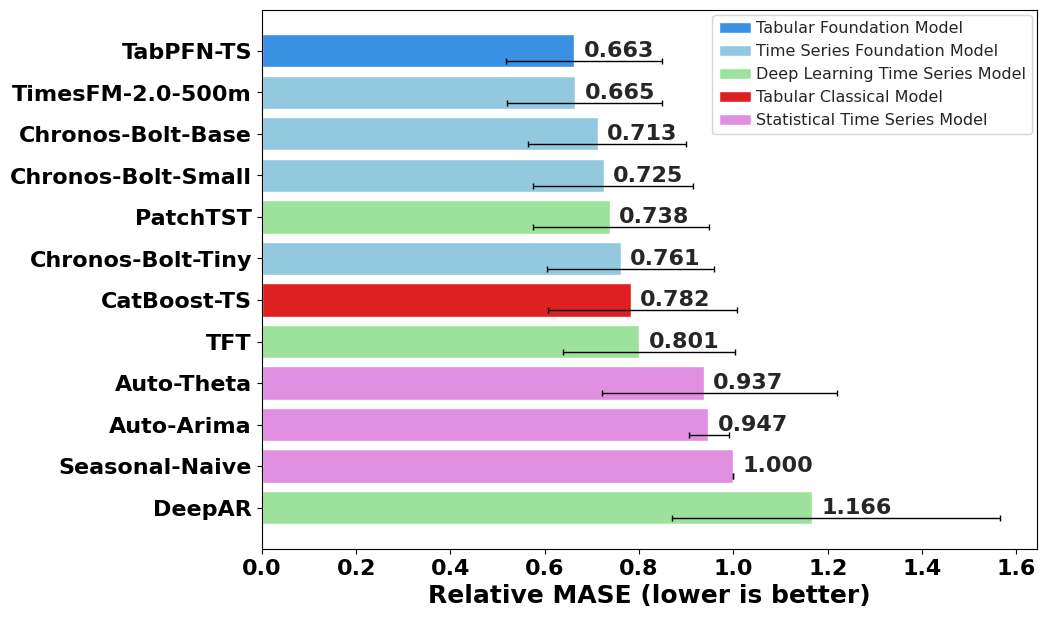

In [8]:
from tabpfn_time_series.experimental.visualization.plotting import (
    plot_metric_comparison_with_model_metadata,
    save_plot_to_pdf,
)

ax, _ = plot_metric_comparison_with_model_metadata(
    norm_mase_mean_and_ci,
    xaxis_label="Relative MASE (lower is better)",
    order=norm_mase_mean_and_ci.sort_values('mean').index.tolist()
)

save_plot_to_pdf(ax.figure, "catboost_vs_tabpfn.pdf")